# Open AI GYM - Breakout

## Imports

In [1]:
import gym
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import deque
import time
import random

RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)

In [2]:
game = "ALE/Breakout-v5"
rendermode = "rgb_array"

## Analysing

showing how the game screen looks

Action Space: Discrete(4)
State space: Box(0, 255, (210, 160, 3), uint8)


C:\Users\lowie\.virtualenvs\Project-46Jsvre_\Lib\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


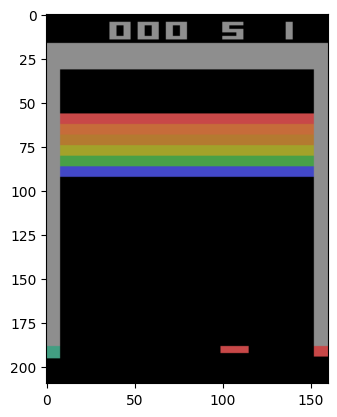

In [3]:
env = gym.make(game, render_mode=rendermode)


print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))
env.reset()
img = plt.imshow(env.render())

Showing the actions and the total

In [4]:
action_meanings = env.unwrapped.get_action_meanings()
num_actions = len(action_meanings)
print(f"Action Meanings: {action_meanings}, Total Actions: {num_actions}")


Action Meanings: ['NOOP', 'FIRE', 'RIGHT', 'LEFT'], Total Actions: 4


Running a random game

In [5]:
import gym
from gym.wrappers import RecordVideo

# Setup environment
directory = './video_random_breakout'
env = RecordVideo(gym.make(game, render_mode=rendermode), video_folder=directory)

# Initialize variables
epochs, rewards = 0, 0
state = env.reset()

# Run the game loop
while True:
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)
    rewards += reward
    epochs += 1
    if done:
        break

# Output the results
print(f"Number of steps: {epochs}")

# Close the environment
env.close()

C:\Users\lowie\.virtualenvs\Project-46Jsvre_\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video C:\Users\lowie\OneDrive - Hogeschool West-Vlaanderen\Documenten\Howest\Howest jaar 2\S2\Reinfocement Learning\Project\video_random_breakout\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\lowie\OneDrive - Hogeschool West-Vlaanderen\Documenten\Howest\Howest jaar 2\S2\Reinfocement Learning\Project\video_random_breakout\rl-video-episode-0.mp4


Moviepy - Done !
Moviepy - video ready C:\Users\lowie\OneDrive - Hogeschool West-Vlaanderen\Documenten\Howest\Howest jaar 2\S2\Reinfocement Learning\Project\video_random_breakout\rl-video-episode-0.mp4
Number of steps: 150


average amount of steps in 100 games

In [6]:
Steps = []
env = gym.make(game)
for episode in range(100):
    n_steps_episode = 0
    total_training_rewards = 0
    observation = env.reset()[0]
    done = False
    while not done:
        action = env.action_space.sample()
        new_observation, reward, done, truncated, info = env.step(action)
        total_training_rewards += reward
        observation = new_observation

        n_steps_episode += 1.

    Steps.append(n_steps_episode)

np.mean(Steps)        

C:\Users\lowie\.virtualenvs\Project-46Jsvre_\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


188.85

First, we define a function to plot the results. We will ask for two plots. In the first plot, all scores are plotted for the consecutive epsisodes. In the second plot, the frequencies of the rewards is given for the last 50 episodes

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_res(values, title=''):
    ''' Plot the reward curve and histogram of results over time.'''

    # Define the figure and axes
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(title, fontsize=16)

    # Plot reward curve (score per episode)
    ax1 = axes[0]
    episodes = np.arange(1, len(values) + 1)
    ax1.plot(episodes, values, label='Score per Episode', color='blue', alpha=0.7)
    ax1.set_xlabel('Episodes', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Training Progress', fontsize=14)
    ax1.axhline(np.mean(values), linestyle='--', color='red', label='Average Score')
    ax1.axhline(220, linestyle='--', color='green', label='Goal Score')
    ax1.legend()

    # Plot histogram of scores from last 100 episodes
    ax2 = axes[1]
    ax2.hist(values[-100:], bins=20, color='green', alpha=0.7)
    ax2.set_xlabel('Score Range', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Score Distribution (Last 100 Episodes)', fontsize=14)
    ax2.axvline(x=220, color='red', linestyle='--', label='Goal Score')
    ax2.legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'values' is a list of scores obtained per episode during training
# plot_res(values, title='Training Results')


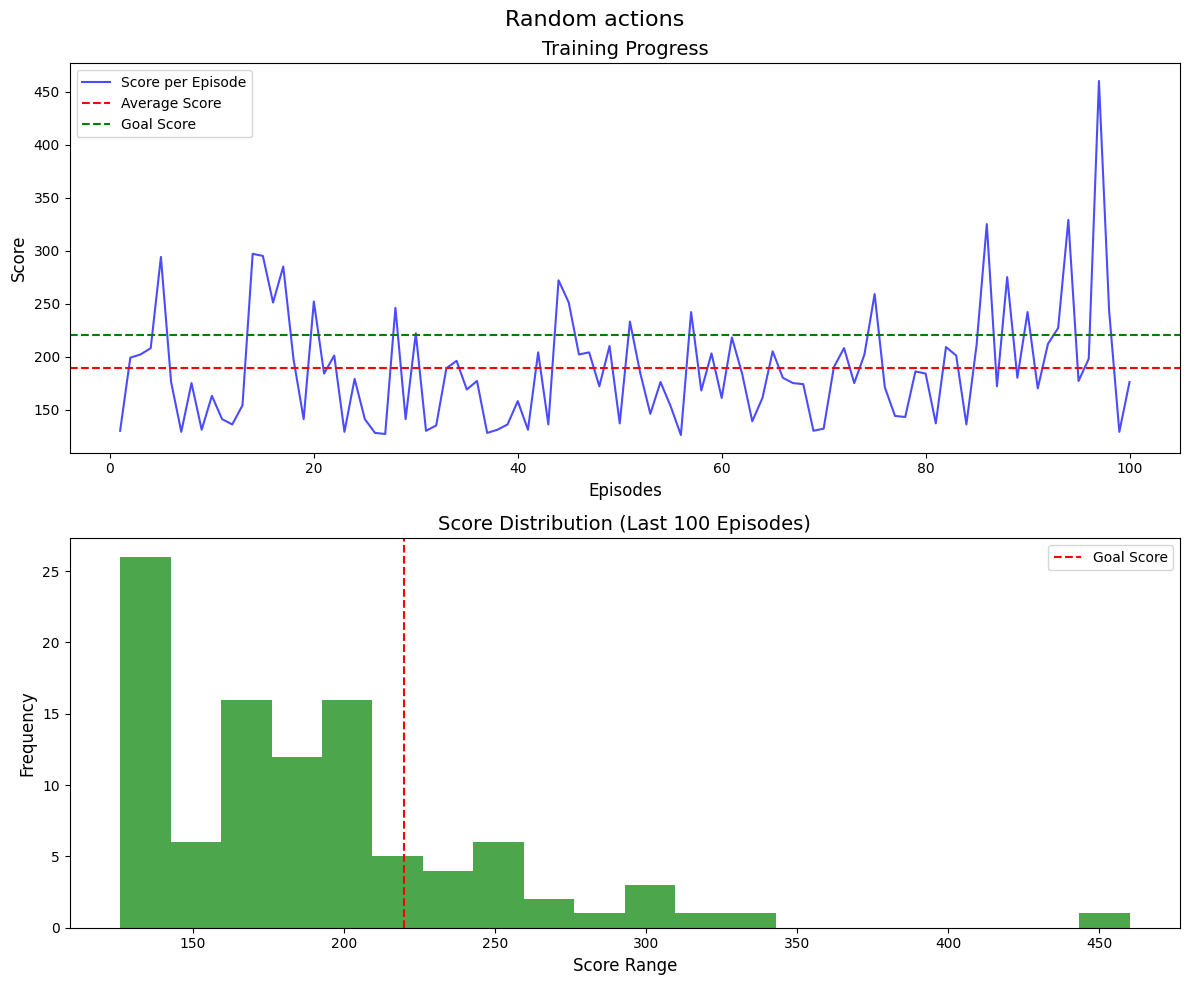

In [8]:
plot_res(Steps,'Random actions')

## Preprocessing

grayscaling + downscaling dimensions

In [9]:
def preprocess_state(state):
    if isinstance(state, tuple):
        state = state[0]  # Unpack the state from the tuple if necessary
    state_gray = np.dot(state[..., :3], [0.299, 0.587, 0.114])  # Convert to grayscale
    state_resized = state_gray[::2, ::2]  # Downsample by a factor of 2
    state_resized = np.uint8(state_resized)  # Convert to uint8
    state_resized = np.expand_dims(state_resized, axis=0)  # Add batch dimension
    state_resized = np.expand_dims(state_resized, axis=-1)  # Add channel dimension
    return state_resized

Action Space: Discrete(4)
State space: Box(0, 255, (210, 160, 3), uint8)


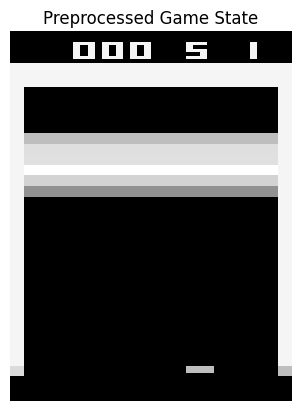

In [10]:
env = gym.make(game, render_mode=rendermode)
print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))

state = env.reset()  # Reset the environment and get the initial state
processed_state = preprocess_state(state)  # Preprocess the initial state

# Display the preprocessed state
plt.figure()
plt.imshow(processed_state[0, ..., 0], cmap='gray')  # Show the first (and only) batch element as grayscale
plt.title('Preprocessed Game State')
plt.axis('off')  # Turn off axis labels
plt.show()

## Define the DQN model

In [11]:
from tensorflow.keras import layers, models, Input

def create_dqn_model(input_shape, num_actions):
    model = models.Sequential([
        Input(shape=input_shape),
        layers.Conv2D(32, (8, 8), strides=(4, 4), activation='relu'),
        layers.Conv2D(64, (4, 4), strides=(2, 2), activation='relu'),
        layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu'),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_actions)
    ])
    return model


## Define the Agent

In [12]:
class DQNAgent:
    def __init__(self, model, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, gamma=0.99):
        self.model = model
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.model.output_shape[-1])  # Random action
        else:
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])  # Greedy action

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


## Define the training loop

In [13]:
def train_dqn(agent, env, num_episodes=1):
    scores = []
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            step_result = env.step(action)

            if isinstance(step_result, tuple) and len(step_result) >= 3:
                next_state, reward, done = step_result[:3]
            else:
                raise ValueError(f"Unexpected step result: {step_result}")

            next_state = preprocess_state(next_state)
            total_reward += reward

            # Store experience in replay buffer and perform model training (not shown)

            state = next_state

        scores.append(total_reward)
        agent.update_epsilon()

        # Print progress every 50 episodes
        if episode % 50 == 0:
            print(f"Episode {episode}/{num_episodes}, Score: {total_reward}, Epsilon: {agent.epsilon}")

    return scores

In [14]:
# Define input shape and number of actions
input_shape = (105, 80, 1)  # Example input shape (height, width, channels)
num_actions = env.action_space.n  # Number of actions in the environment

# Create the DQN model
dqn_model = create_dqn_model(input_shape, num_actions)

# Create the DQNAgent
agent = DQNAgent(model=dqn_model)

# Train the DQN agent
scores = train_dqn(agent, env)

### Saving the model

In [28]:
# Define the path where you want to save the model
model_save_path = "DQN_Model.keras"

# Save the model to the specified path
agent.model.save(model_save_path)

print("Trained model saved to:", model_save_path)

Trained model saved to: DQN_Model.keras


## Visualise Training results

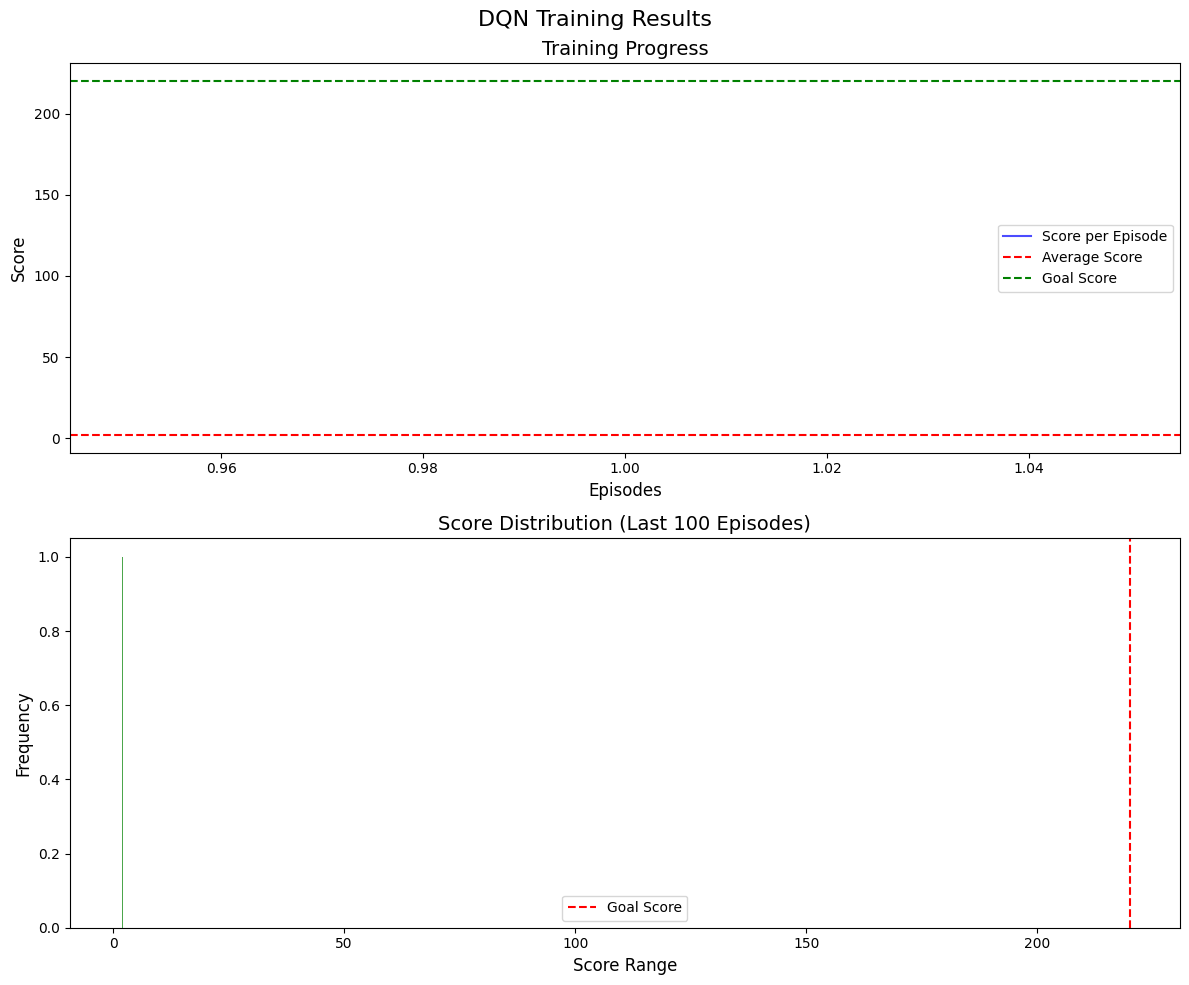

In [29]:
plot_res(scores, title='DQN Training Results')

In [30]:
import gym
from gym.wrappers import RecordVideo
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Define your game and rendering mode
game = "ALE/Breakout-v5"
render_mode = "rgb_array"

# Create the Breakout environment (without video recording)
env = gym.make(game, render_mode=render_mode)

# Load your trained DQN model
dqn_model = load_model(model_save_path)

# Create a video recording folder
directory = './video_dqn_breakout'
env = RecordVideo(env, video_folder=directory)

# Initialize variables
epochs, rewards = 0, 0
state = env.reset()

# Run the game loop with your trained DQN model
while True:
    # Preprocess the current state
    state_preprocessed = preprocess_state(state)

    # Use the DQN model to choose an action
    action = np.argmax(dqn_model.predict(state_preprocessed))

    # Take the chosen action
    state, reward, done, truncated, info = env.step(action)

    # Accumulate rewards
    rewards += reward
    epochs += 1

    # Check if the episode is done
    if done:
        break

# Output the results
print(f"Number of steps: {epochs}, Total rewards: {rewards}")

# Close the environment
env.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

C:\Users\lowie\.virtualenvs\Project-46Jsvre_\Lib\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 